## The first step in using Spark is connecting to a cluster. 
There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called worker. The master sends the workers data and calculations to run, and they send their results back to the master.<br>
<br>
Creating the connection is as simple as creating an instance of the ```SparkContext``` class. The class constructor takes a few optional arguments that allow you to specify the attributes of the cluster you're connecting to.<br>
An object holding all these attributes can be created with the ```SparkConf()``` constructor. 

In [1]:
import pyspark as sp

•	Call print() on sc to verify there's a SparkContext in your environment.<br>
•	print() sc.version to see what version of Spark is running on your cluster.


In [5]:
sc = sp.SparkContext.getOrCreate()
# Verify SparkContext
print(sc)

<SparkContext master=local[*] appName=pyspark-shell>


In [4]:
# Print Spark version
print(sc.version)

<SparkContext master=local[*] appName=pyspark-shell>
2.2.1


## Using DataFrames
Spark's core data structure is the Resilient Distributed Dataset (RDD). This is a low level object that lets Spark work its magic by splitting data across multiple nodes in the cluster. However, RDDs are hard to work with directly, so in this course you'll be using the Spark DataFrame abstraction built on top of RDDs.<br>
<br>
To start working with Spark DataFrames, you first have to create a ```SparkSession``` object from your ```SparkContext```. You can think of the ```SparkContext``` as your connection to the cluster and the ```SparkSession``` as your interface with that connection.


In [6]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 

# Create my_spark
my_spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(my_spark)

### Viewing tables
Once you've created a ```SparkSession```, you can start poking around to see what data is in your cluster!<br>
<br>
Your ```SparkSession``` has an attribute called ```catalog``` which lists all the data inside the cluster. This attribute has a few methods for extracting different pieces of information.<br>
One of the most useful is the ```.listTables()``` method, which returns the names of all the tables in your cluster as a list.


In [7]:
# Print the tables in the catalog
print(my_spark.catalog.listTables())

[]


### Are you query-ious?
Running a query on this table is as easy as using the ```.sql()``` method on your ```SparkSession```. This method takes a string containing the query and returns a DataFrame with the results!

In [ ]:
# Don't change this query
query = "FROM flights SELECT * LIMIT 10"

# Get the first 10 rows of flights
flights10 = spark.sql(query)

# Show the results
flights10.show()

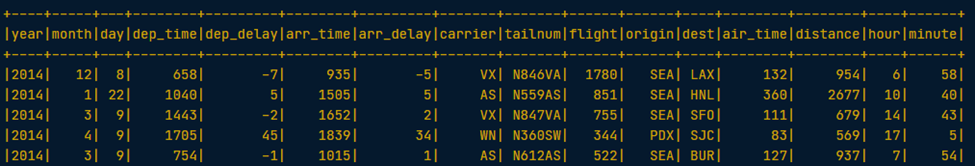

### Pandafy a Spark DataFrame
Suppose you've run a query on your huge dataset and aggregated it down to something a little more manageable.<br>
Sometimes it makes sense to then take that table and work with it locally using a tool like ```pandas```. Spark DataFrames make that easy with the ```.toPandas()``` method. Calling this method on a Spark DataFrame returns the corresponding ```pandas``` DataFrame.


In [ ]:
# Don't change this query
query = "SELECT origin, dest, COUNT(*) as N FROM flights GROUP BY origin, dest"

# Run the query
flight_counts = spark.sql(query)

# Convert the results to a pandas DataFrame
pd_counts = flight_counts.toPandas()

# Print the head of pd_counts
print(pd_counts.head())

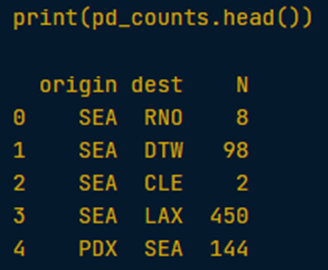

### Put some Spark in your data
The ```.createDataFrame()``` method takes a pandas DataFrame and returns a Spark DataFrame.<br>
<br>
The output of this method is stored locally, not in the SparkSession catalog. This means that you can use all the Spark DataFrame methods on it, but you can't access the data in other contexts.

In [9]:
import pandas as pd
import numpy as np

In [10]:
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = my_spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(my_spark.catalog.listTables())

[]


In [11]:
# Add spark_temp to the catalog
spark_temp.name = spark_temp.createOrReplaceTempView('temp')

# Examine the tables in the catalog again
print(my_spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


Check out the diagram to see all the different ways your Spark data structures interact with each other.
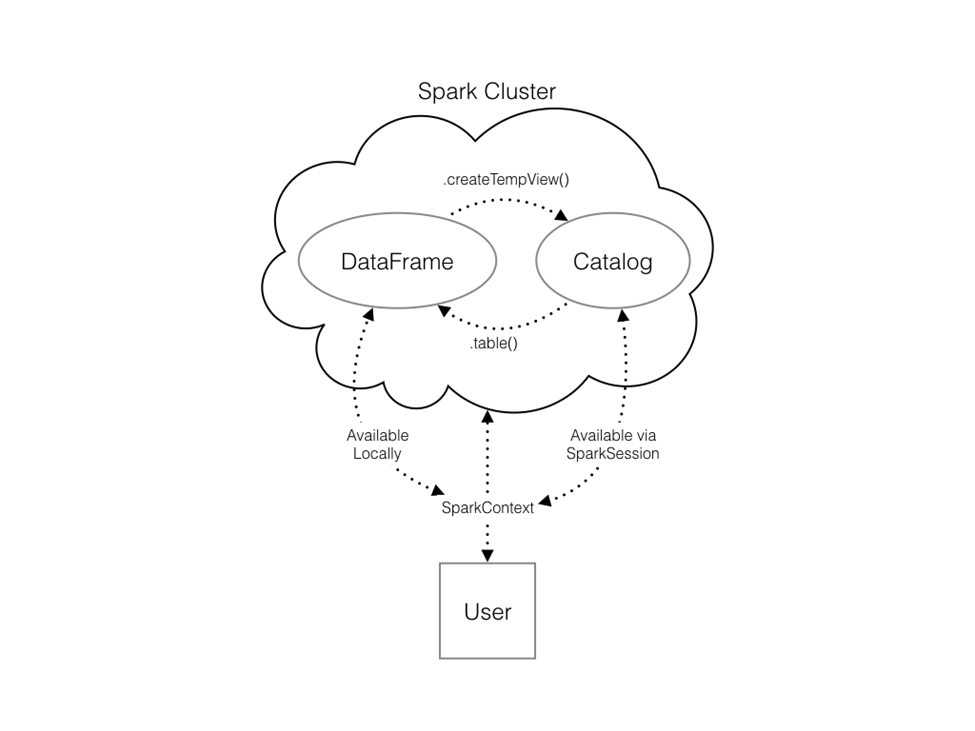

### Dropping the middle man
```SparkSession``` has a ```.read``` attribute which has several methods for reading different data sources into Spark DataFrames. Using these you can create a DataFrame from a .csv file just like with regular ```pandas``` DataFrames!<br><br>
•	Pass the argument ```header=True``` so that Spark knows to take the column names from the first line of the file.

In [12]:
# Don't change this file path
file_path = "airports.csv"

# Read in the airports data
airports = my_spark.read.csv(file_path, header=True)

# Show the data
airports.show()

+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...

## Manipulating data
### Creating columns
In Spark you can do this using the ```.withColumn()``` method, which takes two arguments. First, a string with the name of your new column, and second the new column itself.<br>
Updating a Spark DataFrame is somewhat different than working in pandas because the Spark DataFrame is immutable. This means that it can't be changed, and so columns can't be updated in place.
Thus, all these methods return a new DataFrame. To overwrite the original DataFrame you must reassign the returned DataFrame using the method like so:<br>
```df = df.withColumn("newCol", df.oldCol + 1)```<br>
The above code creates a DataFrame with the same columns as `df` plus a new column, `newCol`, where every entry is equal to the corresponding entry from `oldCol`, plus one.


In [13]:
flights = my_spark.read.csv('flights_small.csv', header=True)
flights.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [17]:
# Create a Temporary table named "flights"
flights.name = flights.createOrReplaceTempView('flights')

In [18]:
# Create the DataFrame flights
flights_1 = my_spark.table('flights')

# Show the head
print(flights_1.show())

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [19]:
# Add duration_hrs
flights = flights.withColumn('duration_hrs', flights.air_time / 60)
flights.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|               2.2|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|              1.85|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|1.3833333333333333|
|2014|    3|  9|     754|  

In [20]:
flights = flights.withColumn('cc', flights.duration_hrs)
flights.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|                cc|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+------------------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|               2.2|               2.2|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|               6.0|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|              1.85|              1.85|
|2014|    4|  9|    1705|       45|    1839|       3

### Filtering Data
The `.filter()` method takes either an expression that would follow the `WHERE` clause of a SQL expression as a string, or a Spark Column of boolean (`True/False`) values.<br><br>
For example, the following two expressions will produce the same output:<br>
`flights.filter("air_time > 120").show()`<br>
`flights.filter(flights.air_time > 120).show()`<br><br>
Notice that in the first case, we pass a string to `.filter()`. In SQL, we would write this filtering task as `SELECT * FROM flights WHERE air_time > 120`. Spark's `.filter()` can accept any expression that could go in the `WHERE` clause of a SQL query (in this case, `"air_time > 120"`), as long as it is passed as a string. <br><br>
In the second case, we actually pass a column of boolean values to `.filter()`. Remember that `flights.air_time > 120` returns a column of boolean values that has `True` in place of those records in `flights.air_time` that are over 120, and `False` otherwise.


In [21]:
# Filter flights with a SQL string
long_flights1 = flights.filter('distance > 1000')

# Filter flights with a boolean column
long_flights2 = flights.filter(flights.distance > 1000)

# Examine the data to check they're equal
print(long_flights1.show())
print(long_flights2.show())

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|                cc|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+------------------+
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|               6.0|
|2014|    4| 19|    1236|       -4|    1508|       -7|     AS| N309AS|   490|   SEA| SAN|     135|    1050|  12|    36|              2.25|              2.25|
|2014|   11| 19|    1812|       -3|    2352|       -4|     AS| N564AS|    26|   SEA| ORD|     198|    1721|  18|    12|               3.3|               3.3|
|2014|    8|  3|    1120|        0|    1415|        

### Selecting
The Spark variant of SQL's `SELECT` is the `.select()` method. This method takes multiple arguments - one for each column you want to select. These arguments can either be the column name as a string (one for each column) or a column object (using the `df.colName` syntax).<br><br>
The difference between `.select()` and `.withColumn()` methods is that `.select()` returns only the columns you specify, while `.withColumn()` returns all the columns of the DataFrame in addition to the one you defined. 


In [22]:
# Select the first set of columns
selected1 = flights.select("tailnum","origin", "dest")

# Select the second set of columns
temp = flights.select(flights.origin, flights.dest, flights.carrier)

# Define first filter
filterA = flights.origin == "SEA"

# Define second filter
filterB = flights.dest == "PDX"

# Filter the data, first by filterA then by filterB
selected2 = temp.filter(filterA).filter(filterB)

### Selecting II
Similar to SQL, you can also use the `.select()` method to perform column-wise operations. When you're selecting a column using the `df.colName` notation, you can perform any column operation and the `.select()` method will return the transformed column. For example,<br><br>
`flights.select(flights.air_time/60)`<br><br>
returns a column of flight durations in hours instead of minutes. You can also use the `.alias()` method to rename a column you're selecting. So if you wanted to `.select()` the column `duration_hrs` (which isn't in your DataFrame) you could do<br><br>
`flights.select((flights.air_time/60).alias("duration_hrs"))`<br><br>
The equivalent Spark DataFrame method `.selectExpr()` takes SQL expressions as a string:<br><br>
`flights.selectExpr("air_time/60 as duration_hrs")`<br><br>
with the SQL as keyword being equivalent to the `.alias()` method. To select multiple columns, you can pass multiple strings.


In [23]:
# Define avg_speed
avg_speed = (flights.distance/(flights.air_time/60)).alias("avg_speed")

# Select the correct columns
speed1 = flights.select("origin", "dest", "tailnum", avg_speed)

# Create the same table using a SQL expression
speed2 = flights.selectExpr("origin", "dest", "tailnum", "distance/(air_time/60) as avg_speed")

### Aggregating
`df.groupBy().min("col").show()`<br><br>
This creates a `GroupedData` object (so you can use the `.min()` method), then finds the minimum value in `col`, and returns it as a DataFrame.


In [25]:
flights.describe()

DataFrame[summary: string, year: string, month: string, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: string, carrier: string, tailnum: string, flight: string, origin: string, dest: string, air_time: string, distance: string, hour: string, minute: string, duration_hrs: string, cc: string]

When we imported our data, we let Spark guess what kind of information each column held. Unfortunately, Spark doesn't always guess right and you can see that some of the columns in our DataFrame are strings containing numbers as opposed to actual numeric values.<br><br>Using the `.cast()` method in combination with the `.withColumn()` method to convert the data type.(It's important to note that .cast() works on columns, while .withColumn() works on DataFrames.)


In [26]:
# convert string to numeric 
flights = flights.withColumn("distance", flights.distance.cast("float"))
flights = flights.withColumn("air_time", flights.air_time.cast("float"))

In [27]:
# Find the shortest flight from PDX in terms of distance
flights.filter(flights.origin == "PDX").groupBy().min("distance").show()

# Find the longest flight from SEA in terms of duration
flights.filter(flights.origin == "SEA").groupBy().max("air_time").show()

+-------------+
|min(distance)|
+-------------+
|        106.0|
+-------------+

+-------------+
|max(air_time)|
+-------------+
|        409.0|
+-------------+



### Aggregating II


In [28]:
# Average duration of Delta flights
flights.filter(flights.carrier == "DL").filter(flights.origin == "SEA").groupBy().avg('air_time').show()

# Total hours in the air
flights.withColumn("duration_hrs", flights.air_time/60).groupBy().sum("duration_hrs").show()

+------------------+
|     avg(air_time)|
+------------------+
|188.20689655172413|
+------------------+

+------------------+
| sum(duration_hrs)|
+------------------+
|25289.600000000126|
+------------------+



### Grouping and Aggregating I


In [29]:
# Group by tailnum
by_plane = flights.groupBy("tailnum")

# Number of flights each plane made
by_plane.count().show()

# Group by origin
by_origin = flights.groupBy("origin")

# Average duration of flights from PDX and SEA
by_origin.avg("air_time").show()

+-------+-----+
|tailnum|count|
+-------+-----+
| N442AS|   38|
| N102UW|    2|
| N36472|    4|
| N38451|    4|
| N73283|    4|
| N513UA|    2|
| N954WN|    5|
| N388DA|    3|
| N567AA|    1|
| N516UA|    2|
| N927DN|    1|
| N8322X|    1|
| N466SW|    1|
|  N6700|    1|
| N607AS|   45|
| N622SW|    4|
| N584AS|   31|
| N914WN|    4|
| N654AW|    2|
| N336NW|    1|
+-------+-----+
only showing top 20 rows

+------+------------------+
|origin|     avg(air_time)|
+------+------------------+
|   SEA| 160.4361496051259|
|   PDX|137.11543248288737|
+------+------------------+



### Grouping and Aggregating II
`.agg()` method lets you pass an aggregate column expression that uses any of the aggregate functions from the `pyspark.sql.functions` submodule.

In [30]:
flights = flights.withColumn("dep_delay", flights.dep_delay.cast("float"))

In [31]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# Group by month and dest
by_month_dest = flights.groupBy("month", "dest")

# Average departure delay by month and destination
by_month_dest.avg("dep_delay").show()

# Standard deviation
by_month_dest.agg(F.stddev("dep_delay")).show()

+-----+----+--------------------+
|month|dest|      avg(dep_delay)|
+-----+----+--------------------+
|   11| TUS| -2.3333333333333335|
|   11| ANC|   7.529411764705882|
|    1| BUR|               -1.45|
|    1| PDX| -5.6923076923076925|
|    6| SBA|                -2.5|
|    5| LAX|-0.15789473684210525|
|   10| DTW|                 2.6|
|    6| SIT|                -1.0|
|   10| DFW|  18.176470588235293|
|    3| FAI|                -2.2|
|   10| SEA|                -0.8|
|    2| TUS| -0.6666666666666666|
|   12| OGG|  25.181818181818183|
|    9| DFW|   4.066666666666666|
|    5| EWR|               14.25|
|    3| RDM|                -6.2|
|    8| DCA|                 2.6|
|    7| ATL|   4.675675675675675|
|    4| JFK| 0.07142857142857142|
|   10| SNA| -1.1333333333333333|
+-----+----+--------------------+
only showing top 20 rows

+-----+----+----------------------+
|month|dest|stddev_samp(dep_delay)|
+-----+----+----------------------+
|   11| TUS|    3.0550504633038935|
|   11| ANC|  

### Joining 
`.join()` method takes three arguments. The first is the second DataFrame that you want to join with the first one. The second argument, `on`, is the name of the key column(s) as a string. The names of the key column(s) must be the same in each table. The third argument, `how`, specifies the kind of join to perform. In this course we'll always use the value `how="leftouter"`.


In [32]:
# Examine the data
print(airports.show())

+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...

In [33]:
# Rename the faa column
airports = airports.withColumnRenamed("faa", "dest")

# Join the DataFrames
flights_with_airports = flights.join(airports, on="dest", how="leftouter")

# Examine the data again
print(flights_with_airports.show())

+----+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+--------+--------+----+------+------------------+------------------+--------------------+---------+-----------+----+---+---+
|dest|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|air_time|distance|hour|minute|      duration_hrs|                cc|                name|      lat|        lon| alt| tz|dst|
+----+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+--------+--------+----+------+------------------+------------------+--------------------+---------+-----------+----+---+---+
| LAX|2014|   12|  8|     658|     -7.0|     935|       -5|     VX| N846VA|  1780|   SEA|   132.0|   954.0|   6|    58|               2.2|               2.2|    Los Angeles Intl|33.942536|-118.408075| 126| -8|  A|
| HNL|2014|    1| 22|    1040|      5.0|    1505|        5|     AS| N559AS|   851|   SEA|   360.0|  2677.0|  10|    40|               6.0|      

## Getting started with machine learning pipelines
### Machine Learning Pipelines
At the core of the `pyspark.ml` module are the `Transformer` and `Estimator` classes. Almost every other class in the module behaves similarly to these two basic classes.<br><br>

`Transformer` classes have a `.transform()` method that takes a DataFrame and returns a new DataFrame; usually the original one with a new column appended. For example, you might use the class `Bucketizer` to create discrete bins from a continuous feature or the class `PCA` to reduce the dimensionality of your dataset using principal component analysis.<br><br>

`Estimator` classes all implement a `.fit()` method. These methods also take a DataFrame, but instead of returning another DataFrame they return a model object. This can be something like a `StringIndexerModel` for including categorical data saved as strings in your models, or a `RandomForestModel` that uses the random forest algorithm for classification or regression.



### Join the DataFrames


In [34]:
planes = my_spark.read.csv('planes.csv', header=True)
planes.show()

+-------+----+--------------------+----------------+--------+-------+-----+-----+---------+
|tailnum|year|                type|    manufacturer|   model|engines|seats|speed|   engine|
+-------+----+--------------------+----------------+--------+-------+-----+-----+---------+
| N102UW|1998|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N103US|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N104UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N105UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N107US|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N108UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N109UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA|Turbo-fan|
| N110UW|1999|Fixed wing multi ...|AIRBUS INDUSTRIE|A320-214|      2|  182|   NA

In [35]:
# Rename year column
planes = planes.withColumnRenamed("year", "plane_year")

# Join the DataFrames
model_data = flights.join(planes, on="tailnum", how="leftouter")

model_data.show()

+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+------------------+------------------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|                cc|plane_year|                type|  manufacturer|      model|engines|seats|speed|   engine|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+------------------+------------------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+
| N846VA|2014|   12|  8|     658|     -7.0|     935|       -5|     VX|  1780|   SEA| LAX|   132.0|   954.0|   6|    58|               2.2|               2.2|      2011|Fixed wing multi ...|        AIRBUS|   A320-214|      2|  182|   NA|Turbo-fan|
| N559AS|201

### Data types
it's important to know that Spark only handles numeric data. That means all of the columns in your DataFrame must be either integers or decimals (called 'doubles' in Spark).
### String to integer
To convert the type of a column using the `.cast()` method, you can write code like this:<br>
`dataframe = dataframe.withColumn("col", dataframe.col.cast("new_type"))`

In [36]:
# Cast the columns to integers
model_data = model_data.withColumn("arr_delay", model_data.arr_delay.cast("integer"))
model_data = model_data.withColumn("air_time", model_data.air_time.cast("integer"))
model_data = model_data.withColumn("month", model_data.month.cast("integer"))
model_data = model_data.withColumn("plane_year", model_data.plane_year.cast("integer"))

### Create a new column

In [37]:
# Create the column plane_age
model_data = model_data.withColumn("plane_age", model_data.year - model_data.plane_year)

### Making a Boolean


In [38]:
# Create is_late
model_data = model_data.withColumn("is_late", model_data.arr_delay > 0)

# Convert to an integer
model_data = model_data.withColumn("label", model_data.is_late.cast("integer"))

# Remove missing values
model_data = model_data.filter("arr_delay is not NULL and dep_delay is not NULL and air_time is not NULL and plane_year is not NULL")

### Strings and factors
As you know, Spark requires numeric data for modeling. PySpark has functions for handling this built into the `pyspark.ml.features` submodule. A one-hot vector is a way of representing a categorical feature where every observation has a vector in which all elements are zero except for at most one element, which has a value of one (1).<br><br>

Each element in the vector corresponds to a level of the feature, so it's possible to tell what the right level is by seeing which element of the vector is equal to one (1).<br><br>

The first step to encoding your categorical feature is to create a `StringIndexer`. Members of this class are `Estimators` that take a DataFrame with a column of strings and map each unique string to a number. Then, the `Estimator` returns a `Transformer` that takes a DataFrame, attaches the mapping to it as metadata, and returns a new DataFrame with a numeric column corresponding to the string column.
<br><br>
The second step is to encode this numeric column as a one-hot vector using a `OneHotEncoder`. This works exactly the same way as the `StringIndexer` by creating an `Estimator` and then a `Transformer`. The end result is a column that encodes your categorical feature as a vector that's suitable for machine learning routines!

#### All you have to remember is that you need to create a `StringIndexer` and a `OneHotEncoder`, and the Pipeline will take care of the rest.



### Carrier
create a `StringIndexer` and a `OneHotEncoder` to code the `carrier` column. To do this, you'll call the class constructors with the arguments `inputCol` and `outputCol`.<br>

The `inputCol` is the name of the column you want to index or encode, and the `outputCol` is the name of the new column that the Transformer should create.

In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [41]:
# Create a StringIndexer
carr_indexer = StringIndexer(inputCol="carrier", outputCol="carrier_index")

# Create a OneHotEncoder
carr_encoder = OneHotEncoder(inputCol="carrier_index", outputCol="carrier_fact")

### Destination

In [42]:
# Create a StringIndexer
dest_indexer = StringIndexer(inputCol="dest", outputCol="dest_index")

# Create a OneHotEncoder
dest_encoder = OneHotEncoder(inputCol="dest_index", outputCol="dest_fact")

### Assemble a vector
The last step in the `Pipeline` is to combine all of the columns containing our features into a single column. This has to be done before modeling can take place because every Spark modeling routine expects the data to be in this form. You can do this by storing each of the values from a column as an entry in a vector. Then, from the model's point of view, every observation is a vector that contains all of the information about it and a label that tells the modeler what value that observation corresponds to.
<br><br>
Because of this, the `pyspark.ml.feature` submodule contains a class called `VectorAssembler`. This `Transformer` takes all of the columns you specify and combines them into a new vector column.

In [43]:
from pyspark.ml.feature import VectorAssembler

In [44]:
# Make a VectorAssembler
vec_assembler = VectorAssembler(inputCols=["month", "air_time", "carrier_fact", "dest_fact", "plane_age"], outputCol="features")

### Create the pipeline
`Pipeline` is a class in the `pyspark.ml` module that combines all the `Estimators` and `Transformers` that you've already created. This lets you reuse the same modeling process over and over again by wrapping it up in one simple object. <br><br>
Call the `Pipeline()` constructor with the keyword argument `stages` to create a Pipeline.
* `stages` should be a list holding all the stages you want your data to go through in the pipeline. 

In [45]:
# Import Pipeline
from pyspark.ml import Pipeline

# Make the pipeline
flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, carr_indexer, carr_encoder, vec_assembler])

### Test vs. Train
In Spark it's important to make sure you split the data **after** all the transformations. This is because operations like `StringIndexer` don't always produce the same index even when given the same list of strings.

### Transform the data


In [46]:
# Fit and transform the data
piped_data = flights_pipe.fit(model_data).transform(model_data)

In [47]:
piped_data.show()

+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+------------------+------------------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+---------+-------+-----+----------+---------------+-------------+--------------+--------------------+
|tailnum|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|                cc|plane_year|                type|  manufacturer|      model|engines|seats|speed|   engine|plane_age|is_late|label|dest_index|      dest_fact|carrier_index|  carrier_fact|            features|
+-------+----+-----+---+--------+---------+--------+---------+-------+------+------+----+--------+--------+----+------+------------------+------------------+----------+--------------------+--------------+-----------+-------+-----+-----+---------+---------+-------+-----+----------+---------------+-------

### Split the data
* Use the DataFrame method `.randomSplit()` to split `piped_data` into two pieces, `training` with 60% of the data, and `test` with 40% of the data by passing the list `[.6, .4]` to the `.randomSplit()` method.

In [48]:
# Split the data into training and test sets
training, test = piped_data.randomSplit([.6, .4])

## Model tuning and selection
Logistic regression is very similar to a linear regression, but instead of predicting a numeric variable, it predicts the probability (between 0 and 1) of an event.<br>

To use this as a classification algorithm, all you have to do is assign a cutoff point to these probabilities. If the predicted probability is above the cutoff point, you classify that observation as a 'yes' (in this case, the flight being late), if it's below, you classify it as a 'no'!<br>

You'll tune this model by testing different values for several hyperparameters.A hyperparameter is just a value in the model that's not estimated from the data, but rather is supplied by the user to maximize performance.

### Create the modeler
Using is a `LogisticRegression` from the `pyspark.ml.classification` submodule.

In [49]:
# Import LogisticRegression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression Estimator
lr = LogisticRegression()

### Cross validation
tuning the logistic regression model using a procedure called **k-fold cross validation**. This is a method of estimating the model's performance on unseen data (like your test DataFrame).
<br><br>
It works by splitting the training data into a few different partitions. The exact number is up to you. Once the data is split up, one of the partitions is set aside, and the model is fit to the others. Then the error is measured against the held out partition. This is repeated for each of the partitions, so that every block of data is held out and used as a test set exactly once. Then the error on each of the partitions is averaged. This is called the **cross validation** error of the model, and is a good estimate of the actual error on the held out data.
<br><br>
using cross validation to choose the hyperparameters by creating a grid of the possible pairs of values for the two hyperparameters, `elasticNetParam` and `regParam`, and using the cross validation error to compare all the different models so you can choose the best one!

### Create the evaluator
doing cross validation for model selection is a way to compare different models. Luckily, the `pyspark.ml.evaluation` submodule has classes for evaluating different kinds of models. Your model is a binary classification model, so you'll be using the `BinaryClassificationEvaluator` from the `pyspark.ml.evaluation` module.
<br><br>
This evaluator calculates the area under the ROC. This is a metric that combines the two kinds of errors a binary classifier can make (false positives and false negatives) into a simple number. 

In [50]:
# Import the evaluation submodule
import pyspark.ml.evaluation as evals

# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

### Make a grid
next, create a grid of values to search over when looking for the optimal hyperparameters. The submodule `pyspark.ml.tuning` includes a class called `ParamGridBuilder` that does just that <br><br>

You'll need to use the `.addGrid()` and `.build()` methods to create a grid that you can use for cross validation. The `.addGrid()` method takes a model parameter and a list of values that you want to try. The `.build()` method takes no arguments, it just returns the grid that you'll use later.

In [51]:
# Import the tuning submodule
import pyspark.ml.tuning as tune

# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01)) #creates a list of numbers from 0 to .1, incrementing by .01.
grid = grid.addGrid(lr.elasticNetParam, [0,1])

# Build the grid
grid = grid.build()

### Make the validator
The submodule `pyspark.ml.tuning` also has a class called `CrossValidator` for performing cross validation. This `Estimator` takes the modeler you want to fit, the grid of hyperparameters you created, and the evaluator you want to use to compare your models.

In [52]:
# Create the CrossValidator
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator
               )

### Fit the model(s)
`# Fit cross validation models
models = cv.fit(training)`

`# Extract the best model
best_lr = models.bestModel`<br><br>
Remember, the training data is called `training` and you're using `lr` to fit a logistic regression model. Cross validation selected the parameter values `regParam=0` and `elasticNetParam=0` as being the best. These are the default values, so you don't need to do anything else with `lr` before fitting the model.

In [53]:
# Call lr.fit()
best_lr = lr.fit(training)

# Print best_lr
print(best_lr)

LogisticRegression_46238fa2e90048f14e4e


### Evaluating binary classifiers
For this course we'll be using a common metric for binary classification algorithms call the `AUC`, or area under the curve. In this case, the curve is the ROC, or receiver operating curve. The details of what these things actually measure isn't important for this course. All you need to know is that for our purposes, **the closer the AUC is to one (1), the better the model is!**

### Evaluate the model


In [54]:
# Use the model to predict the test set
test_results = best_lr.transform(test)

# Evaluate the predictions
print(evaluator.evaluate(test_results))

0.6956824650229172
